# Proposed Model

### Imports

In [1]:

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import InterpolationMode
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,  Subset, random_split
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import seaborn as sns
import random
import torchvision.transforms.functional as F
from PIL import Image
from Datapreprocess import Applytransform_inception, Applytransform_resnet, AugmentedImageFolder_inception, AugmentedImageFolder_resnet
from sklearn.utils import shuffle
from torchinfo import summary
from torchvision.models import inception_v3
from torch.optim import AdamW  # Import AdamW



### Data Preprocess and Splitting

Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 3701
Inappropriate class size: 3759


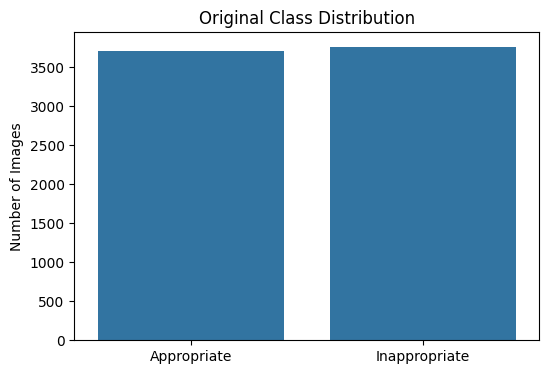

Before Augmentation Train set size: 5222
Before Augmentation Train set size: 5222
After Augmentation Train set size: 10444
Validation set size: 1119
Test set size: 1119
After Augmentation Train set size: 10444
Validation set size: 1119
Test set size: 1119
Balanced class distribution: 3701 appropriate, 3759 inappropriate


In [2]:

# Dataset path
dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"
# dataset_path = "./train_45"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for display
    transforms.ToTensor()
])


dataset = ImageFolder(dataset_path)
dataset_resnet = ImageFolder(dataset_path)
dataset_inception = ImageFolder(dataset_path)
dataset_visual = ImageFolder(dataset_path, transform=transform_visual)  # For showing images

# Extract class names
class_names = dataset_resnet.classes
print(f"Class Names: {class_names}")
# Separate images by class
appropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 0]
inappropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 1]

# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# # Undersample the larger class
# if len(appropriate_indices) > len(inappropriate_indices):
#     appropriate_indices = random.sample(appropriate_indices, len(inappropriate_indices))

# # Merge the balanced indices and shuffle
# balanced_indices = appropriate_indices + inappropriate_indices
# balanced_indices = shuffle(balanced_indices)
# 🔹 **Plot balanced class distribution**
# plt.figure(figsize=(6, 4))
# sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
# plt.title("Balanced Class Distribution")
# plt.ylabel("Number of Images")
# plt.show()

# ALL INDICES
balanced_indices = list(range(len(dataset)))
balanced_indices = shuffle(balanced_indices)

# Define split sizes (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total length matches

# train_idx, val_idx, test_idx = random_split(dataset_inception, [train_size, val_size, test_size])

# Split indices
train_idx = balanced_indices[:train_size]
val_idx = balanced_indices[train_size:train_size + val_size]
test_idx = balanced_indices[train_size + val_size:]

# Create subsets for ResNet
train_resnet = Subset(dataset, train_idx)
val_resnet = Subset(dataset, val_idx)
test_resnet = Subset(dataset, test_idx)


# Create subsets for Inception (using the same indices)
train_inception = Subset(dataset, train_idx)
val_inception = Subset(dataset, val_idx)
test_inception = Subset(dataset, test_idx)
print(f"Before Augmentation Train set size: {len(train_resnet)}")
print(f"Before Augmentation Train set size: {len(train_inception)}")


train_resnet = AugmentedImageFolder_resnet(train_resnet)
train_inception = AugmentedImageFolder_inception(train_inception)

# Apply transformations to val & test sets
val_resnet = Applytransform_resnet(val_resnet)
test_resnet = Applytransform_resnet(test_resnet)

val_inception = Applytransform_inception(val_inception)
test_inception = Applytransform_inception(test_inception)

train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True, num_workers=4)
val_loader_resnet = DataLoader(val_resnet, batch_size=32, shuffle=False, num_workers=4)
test_loader_resnet = DataLoader(test_resnet, batch_size=32, shuffle=False, num_workers=4)

train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True, num_workers=4)
val_loader_inception = DataLoader(val_inception, batch_size=32, shuffle=False, num_workers=4)
test_loader_inception = DataLoader(test_inception, batch_size=32, shuffle=False, num_workers=4)

print(f"After Augmentation Train set size: {len(train_resnet)}")
print(f"Validation set size: {len(val_resnet)}")
print(f"Test set size: {len(test_resnet)}")

print(f"After Augmentation Train set size: {len(train_inception)}")
print(f"Validation set size: {len(val_inception)}")
print(f"Test set size: {len(test_inception)}")


# Check class distribution in the balanced dataset
print(f"Balanced class distribution: {len(appropriate_indices)} appropriate, {len(inappropriate_indices)} inappropriate")



## sample images

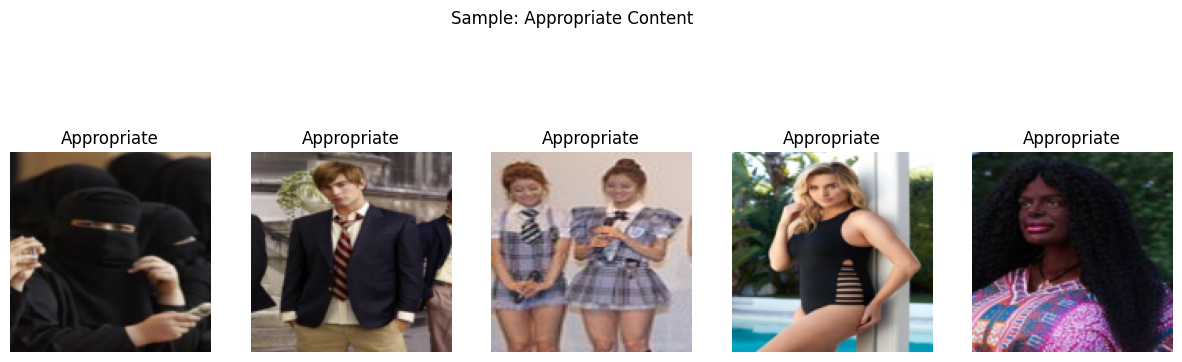

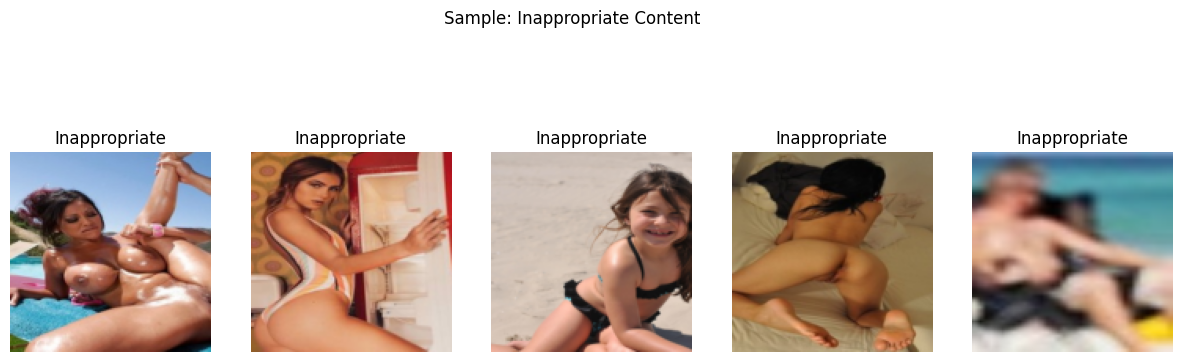

In [5]:
# Sample and show images from both classes
def show_images(indices, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(random.sample(indices, num_images)):
        img, label = dataset_visual[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_images(appropriate_indices, "Sample: Appropriate Content")
show_images(inappropriate_indices, "Sample: Inappropriate Content")




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.64].
Clipping input d

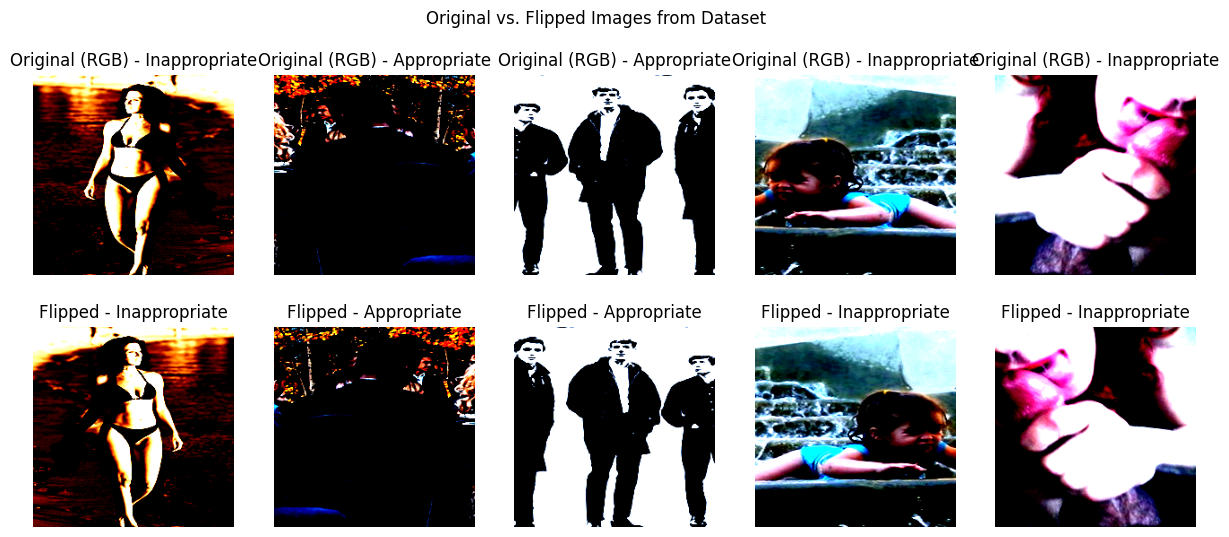

In [6]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented (flipped) images
def show_original_vs_augmented(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 2 - 1)  # Select original images only
        original_idx = index * 2  # Original image index
        flipped_idx = original_idx + 1  # Flipped image index

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # ✅ Check if image is in RGB mode
        if mode_original != "RGB":
            print(f"Warning: Image {img_path} is in {mode_original} mode. Converting to RGB.")
            img_pil = img_pil.convert("RGB")

        # Load images from train_dataset (already transformed)
        img_original, label_original = train_dataset[original_idx]
        img_flipped, label_flipped = train_dataset[flipped_idx]

        # Move tensors to CPU before converting to numpy
        img_original_np = img_original.cpu().permute(1, 2, 0).numpy()
        img_flipped_np = img_flipped.cpu().permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original_np)
        axes[0, i].set_title(f"Original ({mode_original}) - {raw_dataset.classes[label_original]}")
        axes[0, i].axis("off")

        # Display flipped
        axes[1, i].imshow(img_flipped_np)
        axes[1, i].set_title(f"Flipped - {raw_dataset.classes[label_flipped]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Flipped Images from Dataset")
    plt.show()

# Call function using the correct variables
show_original_vs_augmented(train_resnet, dataset)


## Model Initialization

In [9]:

# # Define the model
# class FusionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(FusionModel, self).__init__()
        
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         self.inception = models.inception_v3(aux_logits=False)
#         state_dict = pretrained_model.state_dict()
#         self.inception.load_state_dict(state_dict, strict=False)
        
#         # Step 1: Freeze All Layers Initially**
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         for param in self.inception.parameters():
#             param.requires_grad = False
        
#         # for param in self.resnet.fc.parameters():
#         #       param.requires_grad = True
#         # for param in self.inception.fc.parameters():
#         #       param.requires_grad = True    
              
#         self.resnet.fc = nn.Identity()
#         self.inception.fc = nn.Identity()
                   
#         # self.resnet.fc = None
#         # self.inception.fc = None
        
#         self.batch_norm = nn.BatchNorm1d(4096)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(4096, num_classes)
        
#     def forward(self, x_resnet, x_inception):
#         resnet_features = self.resnet(x_resnet)
#         print(f"ResNet Features Shape: {resnet_features.shape}")  # Debugging Output
#         inception_features = self.inception(x_inception)
#         print(f"ResNet Features Shape: {inception_features.shape}")  # Debugging Output

#         if isinstance(inception_features, tuple):  # InceptionV3 returns a tuple
#             inception_features = inception_features[0]  # Take only the main output
#         fused_features = torch.cat((resnet_features, inception_features), dim=1)
#         fused_features = self.batch_norm(fused_features)
#         fused_features = self.relu(fused_features)
#         fused_features = self.dropout(fused_features)
#         output = torch.sigmoid(self.fc(fused_features))
#         output = self.fc(fused_features)  # No sigmoid here

#         return output

class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super(FusionModel, self).__init__()

        # Load pretrained ResNet50 and freeze all layers
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Identity()  # Remove ResNet FC layer

        # Load pretrained InceptionV3
        # self.inception = models.inception_v3(aux_logits=False)
        # pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        # state_dict = pretrained_model.state_dict()
        # self.inception.load_state_dict(state_dict, strict=False)

        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        inception_model = models.inception_v3(aux_logits=False)
        inception_model.load_state_dict(pretrained_model.state_dict(), strict=False)


        # Freeze all Inception layers
        
        inception_model.fc = nn.Identity()
        self.inception_preprocess = nn.Sequential(
            inception_model.Conv2d_1a_3x3,
            inception_model.Conv2d_2a_3x3,
            inception_model.Conv2d_2b_3x3,
            inception_model.maxpool1,
            inception_model.Conv2d_3b_1x1,
            inception_model.Conv2d_4a_3x3,
            inception_model.maxpool2,
            inception_model.Mixed_5b,
            inception_model.Mixed_5c,
            inception_model.Mixed_5d,
            inception_model.Mixed_6a,
            inception_model.Mixed_6b,
            inception_model.Mixed_6c
        )

        # ✅ **Only keep high-level Inception layers**
        self.inception_top_layers = nn.Sequential(
            inception_model.Mixed_6d,
            inception_model.Mixed_6e,
            inception_model.Mixed_7a,
            inception_model.Mixed_7b,
            inception_model.Mixed_7c,
            nn.AdaptiveAvgPool2d((1, 1)),  # Global avg pooling
            # nn.Flatten()  # Flatten to 1D
        )
        
        for param in inception_model.parameters():
            param.requires_grad = False
            

        # Free memory
        # del pretrained_model

        # Feature sizes
        resnet_out_features = 2048  # ResNet50 last layer output
        inception_out_features = 2048  # InceptionV3 last layer output

        # Fully connected fusion head
        self.batch_norm = nn.BatchNorm1d(resnet_out_features + inception_out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(resnet_out_features + inception_out_features, num_classes)

    def forward(self, x_resnet, x_inception):
        # Extract ResNet50 features
        resnet_features = self.resnet(x_resnet)
        # print(f"ResNet Features Shape: {resnet_features.shape}")  # Debugging Output


        # ✅ **Process input through necessary Inception layers to get correct shape**
        x_inception = self.inception_preprocess(x_inception)
        # print(f"Inception Features Shape: {x_inception.shape}")  # Debugging Output

        inception_features = self.inception_top_layers(x_inception).squeeze(-1).squeeze(-1)        
        # print(f"Inception Features Shape: {inception_features.shape}")  # Debugging Output

        # Concatenate features
        
        fused_features = torch.cat((resnet_features, inception_features), dim=1)
        fused_features = self.batch_norm(fused_features)
        fused_features = self.relu(fused_features)
        fused_features = self.dropout(fused_features)
        output = torch.sigmoid(self.fc(fused_features))

        return output
    
    
model = FusionModel(num_classes=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)




In [4]:
import torch

# Example Input (Batch Size = 2, Channels = 3, Image Size = 224x224)
x_resnet = torch.randn(2, 3, 224, 224)  # Input for ResNet50
x_inception = torch.randn(2, 3, 299, 299)  # Input for InceptionV3

model = FusionModel(num_classes=1)  # Assuming binary classification
output = model(x_resnet, x_inception)


### model summary

In [10]:


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
# print(model)
summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

resnet.conv1.weight: Frozen
resnet.bn1.weight: Frozen
resnet.bn1.bias: Frozen
resnet.layer1.0.conv1.weight: Frozen
resnet.layer1.0.bn1.weight: Frozen
resnet.layer1.0.bn1.bias: Frozen
resnet.layer1.0.conv2.weight: Frozen
resnet.layer1.0.bn2.weight: Frozen
resnet.layer1.0.bn2.bias: Frozen
resnet.layer1.0.conv3.weight: Frozen
resnet.layer1.0.bn3.weight: Frozen
resnet.layer1.0.bn3.bias: Frozen
resnet.layer1.0.downsample.0.weight: Frozen
resnet.layer1.0.downsample.1.weight: Frozen
resnet.layer1.0.downsample.1.bias: Frozen
resnet.layer1.1.conv1.weight: Frozen
resnet.layer1.1.bn1.weight: Frozen
resnet.layer1.1.bn1.bias: Frozen
resnet.layer1.1.conv2.weight: Frozen
resnet.layer1.1.bn2.weight: Frozen
resnet.layer1.1.bn2.bias: Frozen
resnet.layer1.1.conv3.weight: Frozen
resnet.layer1.1.bn3.weight: Frozen
resnet.layer1.1.bn3.bias: Frozen
resnet.layer1.2.conv1.weight: Frozen
resnet.layer1.2.bn1.weight: Frozen
resnet.layer1.2.bn1.bias: Frozen
resnet.layer1.2.conv2.weight: Frozen
resnet.layer1.2.bn2.

## Plots

In [11]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

In [13]:
# Training loop
def train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception, 
                criterion, optimizer, epochs=5,scheduler=None):
   
    
    # for epoch in range(epochs):
    #     if epoch == 2:  # Unfreeze last block of ResNet and Inception
    #         for param in model.resnet.layer4.parameters():
    #             param.requires_grad = True
    #         for param in model.inception.Mixed_7c.parameters():  # Last inception block
    #             param.requires_grad = True
        
    #     if epoch == 4:  # Unfreeze more layers gradually
    #         for param in model.resnet.layer3.parameters():
    #             param.requires_grad = True
    #         for param in model.inception.Mixed_7b.parameters():
    #             param.requires_grad = True
                
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
    "epoch": [],
    "class_names": [],
    "confusion_matrix": [],
    "accuracy": [],
    "fpr": [],
    "fnr": [],
    "auc_roc": [],
    "roc_curve_fpr": [],
    "roc_curve_tpr": []
}

       
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm on the zip object directly
        progress_bar = tqdm(zip(train_loader_resnet, train_loader_inception), 
                             total=len(train_loader_resnet), 
                             desc=f"Epoch {epoch+1}/{epochs}")

        for (resnet_batch, inception_batch) in progress_bar:
            x_resnet, y = resnet_batch
            x_inception, _ = inception_batch
            
            # Move data to the appropriate device
            x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)          
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            

        epoch_loss = running_loss / len(train_loader_resnet)
        epoch_acc = 100 * correct / total
       
        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
                x_resnet, y = resnet_batch
                x_inception, _ = inception_batch
                x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)                
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
                
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())


        val_loss /= len(val_loader_resnet)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        
        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")
        
        # Store metrics
       
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
     

        model.train()  # Return model to training mode
        if scheduler:
                # scheduler.step(val_loss)
                print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
                scheduler.step()
                print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

            # scheduler.step()  

    print("Training complete")
   
    # Compute Additional Metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("\nAdditional Metrics:") 
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print
    # Save Additional Metrics
  # Update metrics dictionary for the current epoch (replace `epoch_number` with actual epoch)
    metrics["class_names"].append(class_names)
    metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    metrics["fpr"].append(fpr)
    metrics["fnr"].append(fnr)
    metrics["auc_roc"].append(auc_score)
    metrics["roc_curve_fpr"].append(fpr_vals)
    metrics["roc_curve_tpr"].append(tpr_vals)
   
    return history, metrics  # Return history dictionary for immediate plotting if needed


### Fine Tune layers

In [16]:
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR

for param in model.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
# for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# # Unfreezing the last few Inception blocks
# for param in model.inception_top_layers[0].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[1].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[2].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True

# for param in model.inception_top_layers[3].parameters():  # Unfreeze Mixed_7b
#     param.requires_grad = True

for param in model.inception_top_layers[4].parameters():  # Unfreeze Mixed_7c
    param.requires_grad = True


# for param in model.inception_top_layers.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception_top_layers.Mixed_7a.parameters():
#     param.requires_grad = True
    
# for param in model.inception.Mixed_7c.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7a.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6e.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6d.parameters():
#     param.requires_grad = True


# for layer in [model.inception.Mixed_6d, model.inception.Mixed_6e,
#               model.inception.Mixed_7a, model.inception.Mixed_7b,
#               model.inception.Mixed_7c]:
#     for param in layer.parameters():
#         param.requires_grad = True

# for param in model.inception_preprocess.parameters():
#     param.requires_grad = True


# print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


resnet.conv1.weight: Frozen
resnet.bn1.weight: Frozen
resnet.bn1.bias: Frozen
resnet.layer1.0.conv1.weight: Frozen
resnet.layer1.0.bn1.weight: Frozen
resnet.layer1.0.bn1.bias: Frozen
resnet.layer1.0.conv2.weight: Frozen
resnet.layer1.0.bn2.weight: Frozen
resnet.layer1.0.bn2.bias: Frozen
resnet.layer1.0.conv3.weight: Frozen
resnet.layer1.0.bn3.weight: Frozen
resnet.layer1.0.bn3.bias: Frozen
resnet.layer1.0.downsample.0.weight: Frozen
resnet.layer1.0.downsample.1.weight: Frozen
resnet.layer1.0.downsample.1.bias: Frozen
resnet.layer1.1.conv1.weight: Frozen
resnet.layer1.1.bn1.weight: Frozen
resnet.layer1.1.bn1.bias: Frozen
resnet.layer1.1.conv2.weight: Frozen
resnet.layer1.1.bn2.weight: Frozen
resnet.layer1.1.bn2.bias: Frozen
resnet.layer1.1.conv3.weight: Frozen
resnet.layer1.1.bn3.weight: Frozen
resnet.layer1.1.bn3.bias: Frozen
resnet.layer1.2.conv1.weight: Frozen
resnet.layer1.2.bn1.weight: Frozen
resnet.layer1.2.bn1.bias: Frozen
resnet.layer1.2.conv2.weight: Frozen
resnet.layer1.2.bn2.

### Train Model

In [14]:
# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.0001)
train_loader_resnet = DataLoader(train_resnet, batch_size=64, shuffle=True, num_workers=4)
train_loader_inception = DataLoader(train_inception, batch_size=64, shuffle=True, num_workers=4)

Fsecondhistory, Fsecondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=5)

Epoch 1/5: 100%|██████████| 164/164 [01:51<00:00,  1.46it/s, accuracy=73.5, loss=0.386]



Epoch 1/5: Train Loss = 0.5377, Train Accuracy = 73.50%
Validation Loss = 0.3807, Validation Accuracy = 86.68%



Epoch 2/5: 100%|██████████| 164/164 [01:42<00:00,  1.59it/s, accuracy=86, loss=0.273]  



Epoch 2/5: Train Loss = 0.3642, Train Accuracy = 85.96%
Validation Loss = 0.3022, Validation Accuracy = 88.92%



Epoch 3/5: 100%|██████████| 164/164 [01:55<00:00,  1.42it/s, accuracy=87, loss=0.691]  



Epoch 3/5: Train Loss = 0.3163, Train Accuracy = 87.02%
Validation Loss = 0.2704, Validation Accuracy = 89.01%



Epoch 4/5: 100%|██████████| 164/164 [01:46<00:00,  1.55it/s, accuracy=88.1, loss=0.36] 



Epoch 4/5: Train Loss = 0.2928, Train Accuracy = 88.06%
Validation Loss = 0.2550, Validation Accuracy = 90.08%



Epoch 5/5: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s, accuracy=88.9, loss=0.298]



Epoch 5/5: Train Loss = 0.2745, Train Accuracy = 88.86%
Validation Loss = 0.2433, Validation Accuracy = 89.63%

Training complete

Additional Metrics:
False Positive Rate (FPR): 0.1048
False Negative Rate (FNR): 0.1026
AUC-ROC Score: 0.9677
TN: 487, FP: 57, FN: 59, TP: 516


In [8]:
# "DECAYING LEARNING RATE"
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00025, weight_decay=0.0001)

            # Set DataLoaders
train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True)
train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True)

            # Use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00009)
            # Train the model
Fsecondhistory, Fsecondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=5, scheduler=scheduler)

Epoch 1/5: 100%|██████████| 327/327 [12:45<00:00,  2.34s/it, accuracy=95.5, loss=0.088]  



Epoch 1/5: Train Loss = 0.1293, Train Accuracy = 95.49%
Validation Loss = 0.3487, Validation Accuracy = 90.08%

Before Step Learning Rate: 0.00025
Current Learning Rate: 0.0002347213595499958


Epoch 2/5: 100%|██████████| 327/327 [12:39<00:00,  2.32s/it, accuracy=97.3, loss=0.0495] 



Epoch 2/5: Train Loss = 0.0740, Train Accuracy = 97.34%
Validation Loss = 0.4779, Validation Accuracy = 92.23%

Before Step Learning Rate: 0.0002347213595499958
Current Learning Rate: 0.0001947213595499958


Epoch 3/5: 100%|██████████| 327/327 [12:16<00:00,  2.25s/it, accuracy=98.5, loss=0.0111]  



Epoch 3/5: Train Loss = 0.0422, Train Accuracy = 98.53%
Validation Loss = 0.2065, Validation Accuracy = 93.92%

Before Step Learning Rate: 0.0001947213595499958
Current Learning Rate: 0.00014527864045000422


Epoch 4/5: 100%|██████████| 327/327 [12:18<00:00,  2.26s/it, accuracy=99.3, loss=0.00375] 



Epoch 4/5: Train Loss = 0.0224, Train Accuracy = 99.32%
Validation Loss = 0.1926, Validation Accuracy = 94.91%

Before Step Learning Rate: 0.00014527864045000422
Current Learning Rate: 0.00010527864045000422


Epoch 5/5: 100%|██████████| 327/327 [12:17<00:00,  2.26s/it, accuracy=99.7, loss=0.00637] 



Epoch 5/5: Train Loss = 0.0090, Train Accuracy = 99.72%
Validation Loss = 0.1766, Validation Accuracy = 95.71%

Before Step Learning Rate: 0.00010527864045000422
Current Learning Rate: 9e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0444
False Negative Rate (FNR): 0.0415
AUC-ROC Score: 0.9882
TN: 517, FP: 24, FN: 24, TP: 554


### Model Evaluation using Test Set

In [17]:

model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for (resnet_batch, inception_batch) in zip(test_loader_resnet, test_loader_inception):
        x_resnet, y = resnet_batch
        x_inception, _ = inception_batch
        x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()
        outputs = model(x_resnet, x_inception).squeeze()
        preds = (outputs > 0.5).cpu().int().numpy()

        # Store ground-truth labels and predictions
        y_true.extend(y.cpu().int().numpy())
        y_pred.extend(preds)
        y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
        




# Compute Additional Metrics for Test Set
conf_matrix = confusion_matrix(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_prob)
fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print Test Metrics
print("\nTest Set Metrics:")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print("**Fine-Tuned Model Evaluation**")


report = classification_report(y_true, y_pred)
print(report)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")



Test Set Metrics:
False Positive Rate (FPR): 0.0652
False Negative Rate (FNR): 0.1411
AUC-ROC Score: 0.9666
Confusion Matrix:
[[516  36]
 [ 80 487]]
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       552
           1       0.93      0.86      0.89       567

    accuracy                           0.90      1119
   macro avg       0.90      0.90      0.90      1119
weighted avg       0.90      0.90      0.90      1119

Accuracy Score: 0.8963360142984808


### Training Results

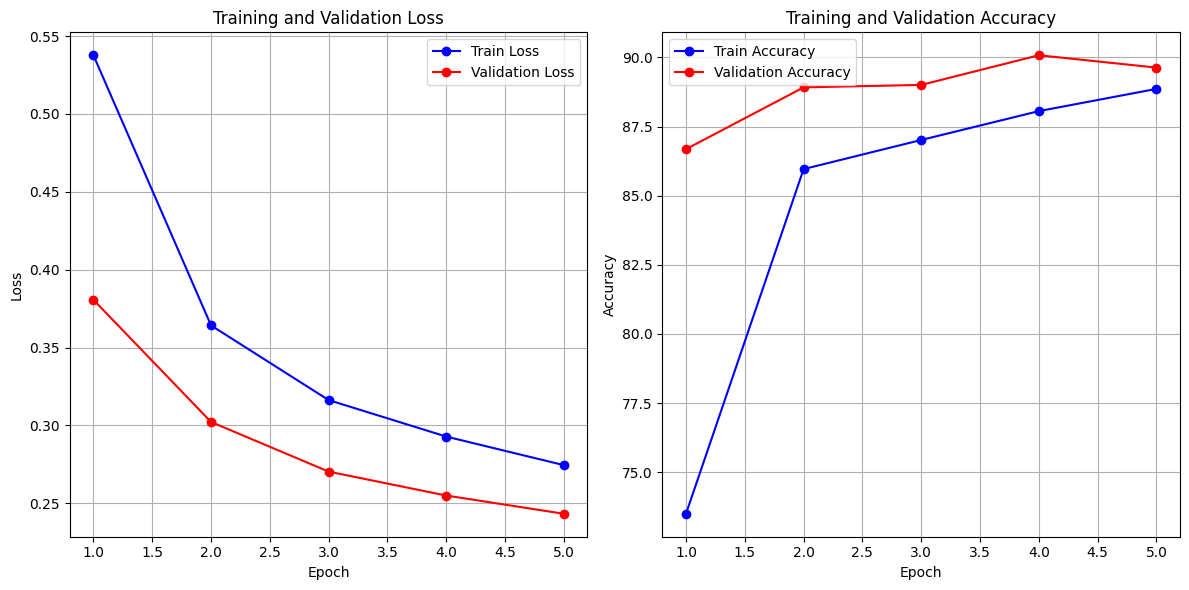

In [15]:
plot_from_history(Fsecondhistory)

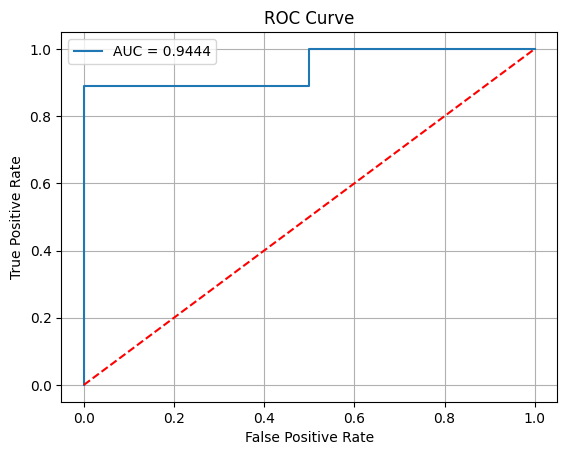

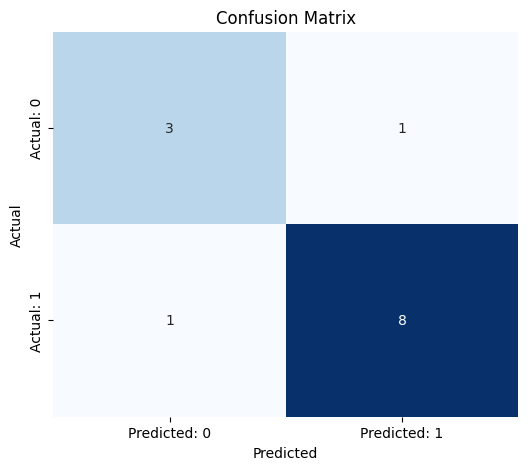

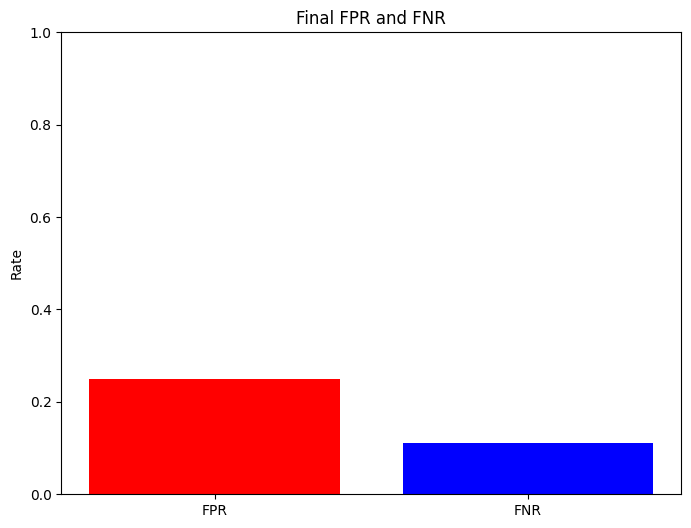

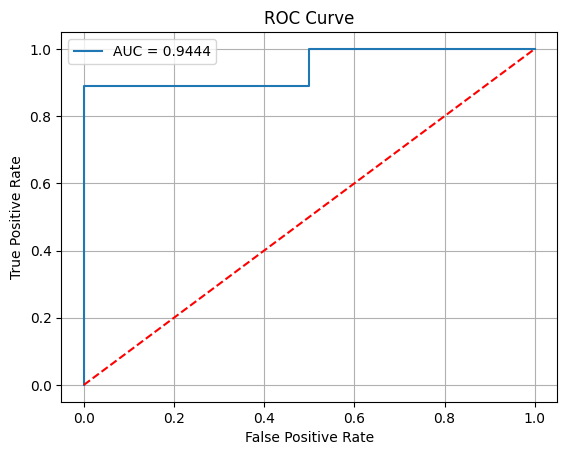

In [ ]:
Fsecondmetrics_flat = {
    "class_names": Fsecondmetrics["class_names"],
    "fpr": Fsecondmetrics["fpr"],
    "fnr": Fsecondmetrics["fnr"],
    "auc_roc": Fsecondmetrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in Fsecondmetrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in Fsecondmetrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in Fsecondmetrics["confusion_matrix"]]
}

plot_roc_curve(Fsecondmetrics_flat)
plot_metrics(Fsecondmetrics_flat)

### Save training results

In [ ]:

with open("training_history/secondproposed_classification_reportv11.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_true, y_pred)}\n") 

df = pd.DataFrame(Fsecondhistory)
df.to_csv('training_history/second_training_historyv7.csv', index=False)
metrics_df = pd.DataFrame(Fsecondmetrics_flat)
metrics_df.to_csv('training_history/second_training_metricsv7.csv', index=False)



#### Read Saved Results

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       541
           1       0.94      0.90      0.92       578

    accuracy                           0.92      1119
   macro avg       0.92      0.92      0.92      1119
weighted avg       0.92      0.92      0.92      1119

Accuracy Score: 0.9204647006255585



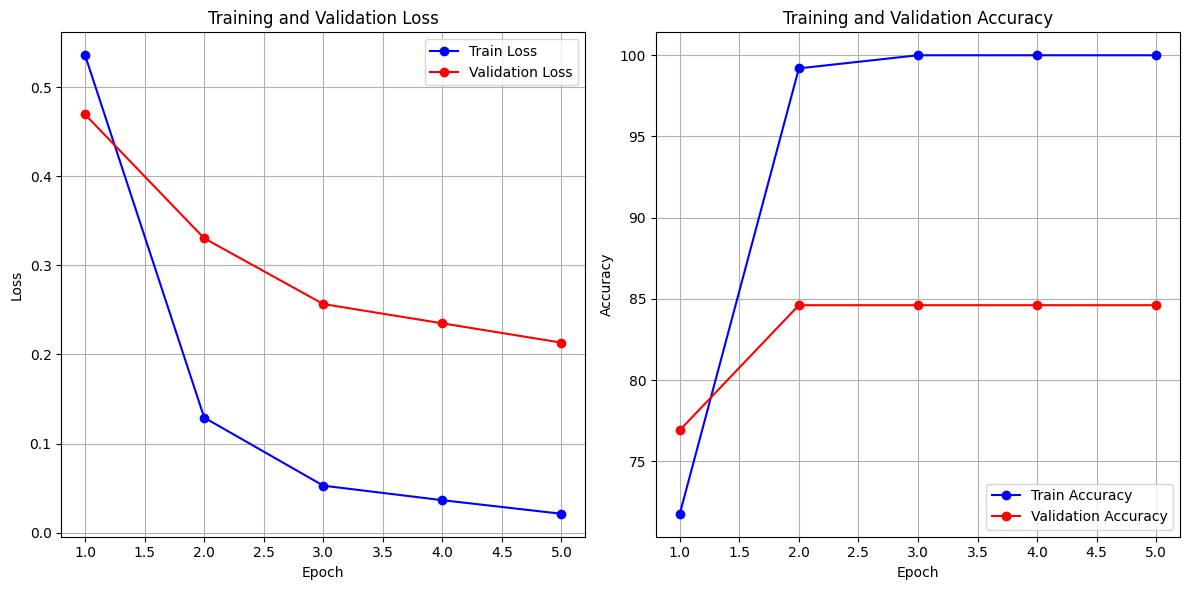

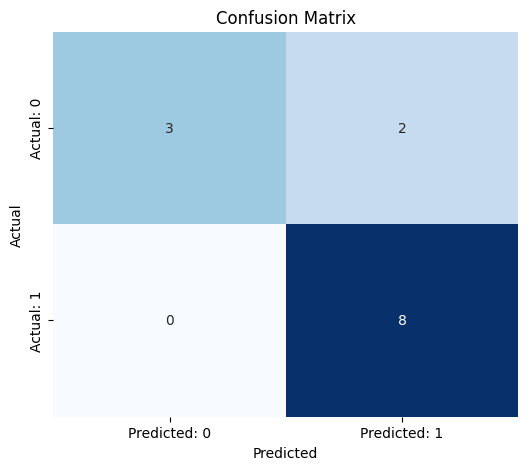

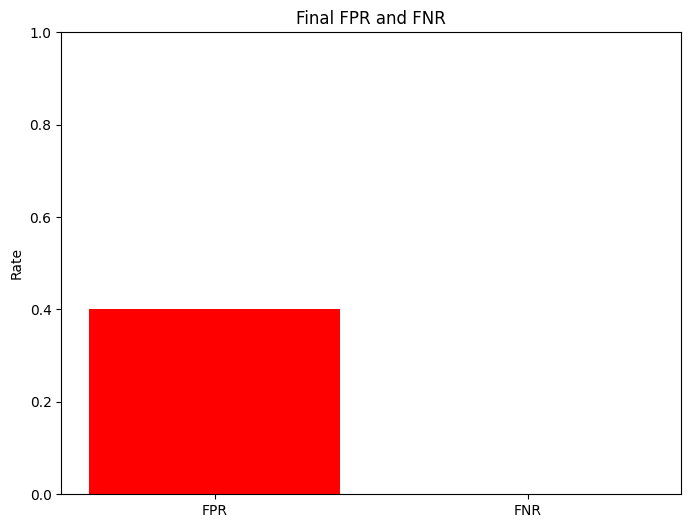

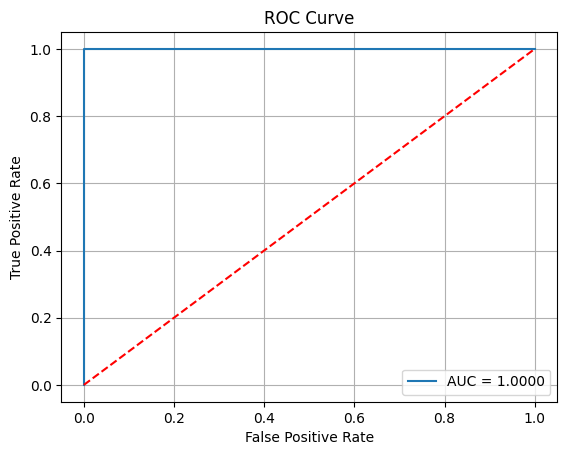

In [ ]:
with open("training_history/secondproposed_classification_reportv9.txt", "r") as file:
    report = file.read()

print(report)

history_df = pd.read_csv('training_history/second_training_historyv7.csv')
Fsecondhistory = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(Fsecondhistory)

metrics_df = pd.read_csv('training_history/second_training_metricsv8.csv')
plot_metrics(metrics_df)

## Save Models

In [ ]:
torch.save(model, "../Saved models/resnet_inception_fullmodel_croppedv8.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("../Saved models/resnet_inception_fullmodel_croppedv8.pt")

#### Use saved model

In [32]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("../Saved models/resnet_inception_fullmodel_croppedv7.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Inappropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Inappropriate


# BASELINE MODEL 

### Imports

In [42]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import InterpolationMode
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from torchvision.models import ResNet50_Weights
import os
import numpy as np
from tqdm import tqdm
import glob
import pandas as pd
from torch.utils.data import DataLoader, Dataset,  Subset
from torchvision.datasets import ImageFolder
import seaborn as sns
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from Datapreprocess import AugmentedImageFolder_resnet, Applytransform_resnet
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import torch.optim as optim
from torchinfo import summary
from torch.optim import AdamW  # Import AdamW




### Data Preprocess and Splitting

Directory found: ./DATASETS/ECD DATASET CROPPED FULL
Contents: ['Appropriate', 'Inappropriate']
Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 3701
Inappropriate class size: 3759


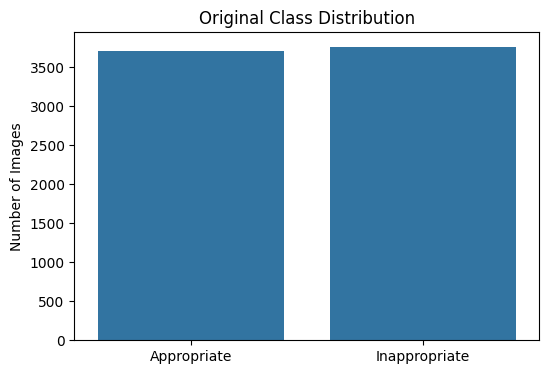

Augmented Training Dataset Size: 10444 (Includes Flipped Images)
Validation Dataset Size: 1119
Test Dataset Size: 1119


In [45]:

# dataset_path = "./train_45"
dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"
if not os.path.exists(dataset_path):
    print(f"Directory not found: {dataset_path}")
else:
    print(f"Directory found: {dataset_path}")
    print("Contents:", os.listdir(dataset_path))

# Define transformations
transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load raw dataset without transformation
dataset_raw = ImageFolder(dataset_path)
class_names = dataset_raw.classes
class_to_idx = dataset_raw.class_to_idx
print("Class Names:", class_names)

# Extract class indices
labels = [label for _, label in dataset_raw.samples]
appropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Appropriate"]]
inappropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Inappropriate"]]


# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")

# Plot original class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# # Balance dataset by undersampling the larger class
# min_class_size = min(len(appropriate_indices), len(inappropriate_indices))
# appropriate_indices = random.sample(appropriate_indices, min_class_size)
# inappropriate_indices = random.sample(inappropriate_indices, min_class_size)

# # Merge & shuffle indices
# balanced_indices = appropriate_indices + inappropriate_indices
# random.shuffle(balanced_indices)

balanced_indices = list(range(len(dataset_raw)))
balanced_indices = shuffle(balanced_indices)


# Define split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(balanced_indices))
val_size = int(0.15 * len(balanced_indices))
test_size = len(balanced_indices) - train_size - val_size

# Split indices
train_indices = balanced_indices[:train_size]
val_indices = balanced_indices[train_size:train_size + val_size]
test_indices = balanced_indices[train_size + val_size:]

# Create Subset datasets
dataset_train = Subset(dataset_raw, train_indices)
dataset_val = Subset(dataset_raw, val_indices)
dataset_test = Subset(dataset_raw, test_indices)

# Wrap in AugmentedImageFolder for flipping
dataset_train = AugmentedImageFolder_resnet(dataset_train)

# Apply transformations to val & test sets
dataset_val = Applytransform_resnet(dataset_val)
dataset_test = Applytransform_resnet(dataset_test)
# Create DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Augmented Training Dataset Size: {len(dataset_train)} (Includes Flipped Images)")
print(f"Validation Dataset Size: {len(dataset_val)}")
print(f"Test Dataset Size: {len(dataset_test)}")





### Sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6051416].
Clipping input data

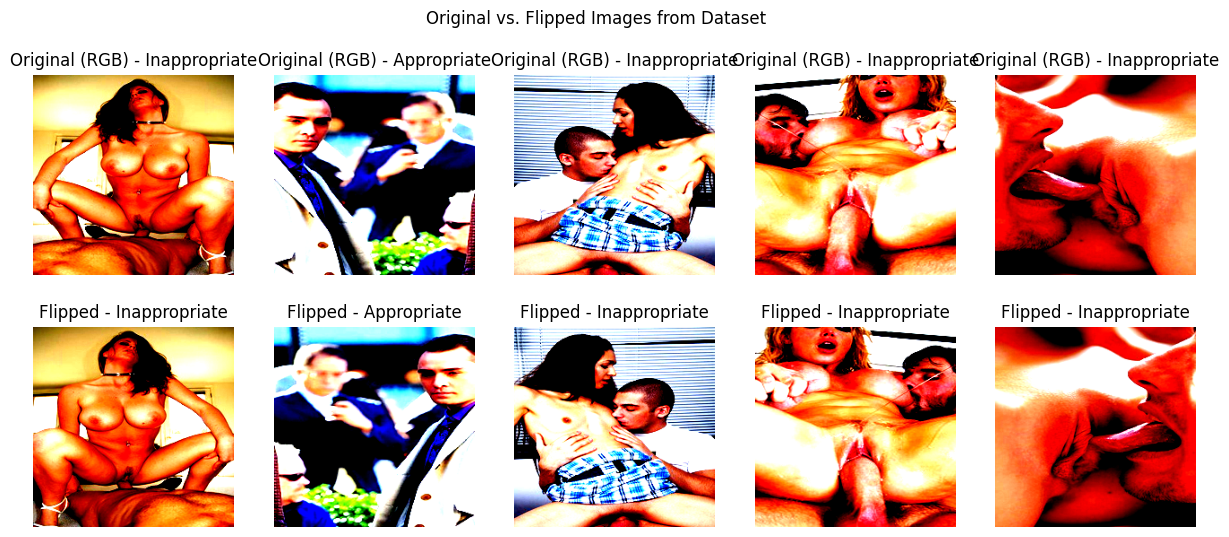

In [46]:
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented (flipped) images with mode check
def show_original_vs_augmented(dataset_train, dataset_raw, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        index = random.randint(0, len(dataset_train) // 2 - 1)  # Select from original images only
        original_idx = index * 2  # Original image index
        flipped_idx = original_idx + 1  # Flipped image index

        # Get original file path (before transformation)
        img_path, label_original = dataset_raw.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # Load images from dataset_train (already transformed)
        img_original, label_original = dataset_train[original_idx]
        img_flipped, label_flipped = dataset_train[flipped_idx]

        # Convert tensors to numpy for display
        img_original_np = img_original.permute(1, 2, 0).numpy()
        img_flipped_np = img_flipped.permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original_np)
        axes[0, i].set_title(f"Original ({mode_original}) - {dataset_raw.classes[label_original]}")
        axes[0, i].axis("off")

        # Display flipped
        axes[1, i].imshow(img_flipped_np)
        axes[1, i].set_title(f"Flipped - {dataset_raw.classes[label_flipped]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Flipped Images from Dataset")
    plt.show()
    

# Show images using `dataset_train`
show_original_vs_augmented(dataset_train, dataset_raw)


## Model Initialization

In [60]:

# class ResNet50Model(nn.Module):
#     def __init__(self):
#         super(ResNet50Model, self).__init__()
        
#         # Load pre-trained ResNet50 model
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
#         # Freeze all layers initially
#         for param in self.resnet.parameters():
#             param.requires_grad = False
        
#         # Replace the fully connected layer
#         self.resnet.fc = nn.Identity()
        
#         # New classification layer
#         self.batch_norm = nn.BatchNorm1d(2048)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(2048, 1)
        
#     def forward(self, x):
#         features = self.resnet(x)
#         features = self.batch_norm(features)
#         features = self.relu(features)
#         features = self.dropout(features)
#         output = torch.sigmoid(self.fc(features))
#         return output
    
    
    
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        
        # Load pre-trained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
   

        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        self.resnet.fc = nn.Identity()
        # Replace the fully connected layer with a new classification layer
        self.resnet.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        output = torch.sigmoid(self.resnet(x))
        return output


base_model_resnet = ResNet50Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model_resnet = base_model_resnet.to(device)


# for param in base_model_resnet.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True



### model summary

In [30]:
torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(base_model_resnet)
summary(base_model_resnet, input_size=(1, 3, 224, 224))

# for name, param in base_model_resnet.named_parameters():
#     print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

ResNet50Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

Layer (type:depth-idx)                        Output Shape              Param #
ResNet50Model                                 [1, 1]                    --
├─ResNet: 1-1                                 [1, 1]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

## Plots

In [48]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

In [49]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Training loop
def train_model_baseline(model, train_loader, val_loader, criterion, optimizer, epochs=5, scheduler=None, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, y = batch
            x_resnet, y = x_resnet.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == y).sum().item()
            total += y.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, y = batch
                x_resnet, y = x_resnet.to(device), y.to(device).float()

                outputs = model(x_resnet).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        model.train()  # Return model to training mode
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    return history, metrics


### Train Model

In [61]:

# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, base_model_resnet.parameters()), lr=0.0001, weight_decay=0.0001)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)
history, metrics = train_model_baseline(base_model_resnet, train_loader, val_loader,criterion, optimizer, epochs=5, device=device )


Epoch 1/5: 100%|██████████| 327/327 [01:16<00:00,  4.29it/s, accuracy=82.2, loss=0.44] 



Epoch 1/5: Train Loss = 0.4973, Train Accuracy = 82.21%
Validation Loss = 0.3927, Validation Accuracy = 87.58%


Additional Metrics:
False Positive Rate (FPR): 0.1314
False Negative Rate (FNR): 0.1173
AUC-ROC Score: 0.9469
TN: 476, FP: 72, FN: 67, TP: 504


Epoch 2/5: 100%|██████████| 327/327 [01:11<00:00,  4.58it/s, accuracy=87.6, loss=0.329]



Epoch 2/5: Train Loss = 0.3501, Train Accuracy = 87.57%
Validation Loss = 0.3323, Validation Accuracy = 88.20%


Additional Metrics:
False Positive Rate (FPR): 0.0748
False Negative Rate (FNR): 0.1594
AUC-ROC Score: 0.9532
TN: 507, FP: 41, FN: 91, TP: 480


Epoch 3/5: 100%|██████████| 327/327 [01:12<00:00,  4.49it/s, accuracy=88.1, loss=0.166]



Epoch 3/5: Train Loss = 0.3106, Train Accuracy = 88.07%
Validation Loss = 0.3005, Validation Accuracy = 88.92%


Additional Metrics:
False Positive Rate (FPR): 0.1077
False Negative Rate (FNR): 0.1138
AUC-ROC Score: 0.9555
TN: 489, FP: 59, FN: 65, TP: 506


Epoch 4/5: 100%|██████████| 327/327 [00:55<00:00,  5.93it/s, accuracy=89, loss=0.203]  



Epoch 4/5: Train Loss = 0.2837, Train Accuracy = 89.05%
Validation Loss = 0.2842, Validation Accuracy = 89.54%


Additional Metrics:
False Positive Rate (FPR): 0.1022
False Negative Rate (FNR): 0.1068
AUC-ROC Score: 0.9581
TN: 492, FP: 56, FN: 61, TP: 510


Epoch 5/5: 100%|██████████| 327/327 [00:54<00:00,  6.02it/s, accuracy=89.4, loss=0.0962]



Epoch 5/5: Train Loss = 0.2702, Train Accuracy = 89.44%
Validation Loss = 0.2813, Validation Accuracy = 88.83%


Additional Metrics:
False Positive Rate (FPR): 0.0639
False Negative Rate (FNR): 0.1576
AUC-ROC Score: 0.9596
TN: 513, FP: 35, FN: 90, TP: 481
Training complete


### Model Eval Using Test Set

In [51]:
base_model_resnet.eval()
y_true, y_pred, y_prob = [], [], []
    
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device).float()
        outputs = base_model_resnet(x).squeeze()
        preds = (outputs > 0.5).cpu().int().numpy()

        # Store ground-truth labels and predictions
        y_true.extend(y.cpu().int().numpy())
        y_pred.extend(preds)
        y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
    
    # Compute Additional Metrics for Test Set
conf_matrix = confusion_matrix(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_prob)
fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
    
 # Print Test Metrics
print("\nTest Set Metrics:")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print("**Fine-Tuned Model Evaluation**")
    
report = classification_report(y_true, y_pred)
print(report)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")
    


Test Set Metrics:
False Positive Rate (FPR): 0.0416
False Negative Rate (FNR): 0.0712
AUC-ROC Score: 0.9853
Confusion Matrix:
[[507  22]
 [ 42 548]]
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       529
           1       0.96      0.93      0.94       590

    accuracy                           0.94      1119
   macro avg       0.94      0.94      0.94      1119
weighted avg       0.94      0.94      0.94      1119

Accuracy Score: 0.9428060768543343


### Training results


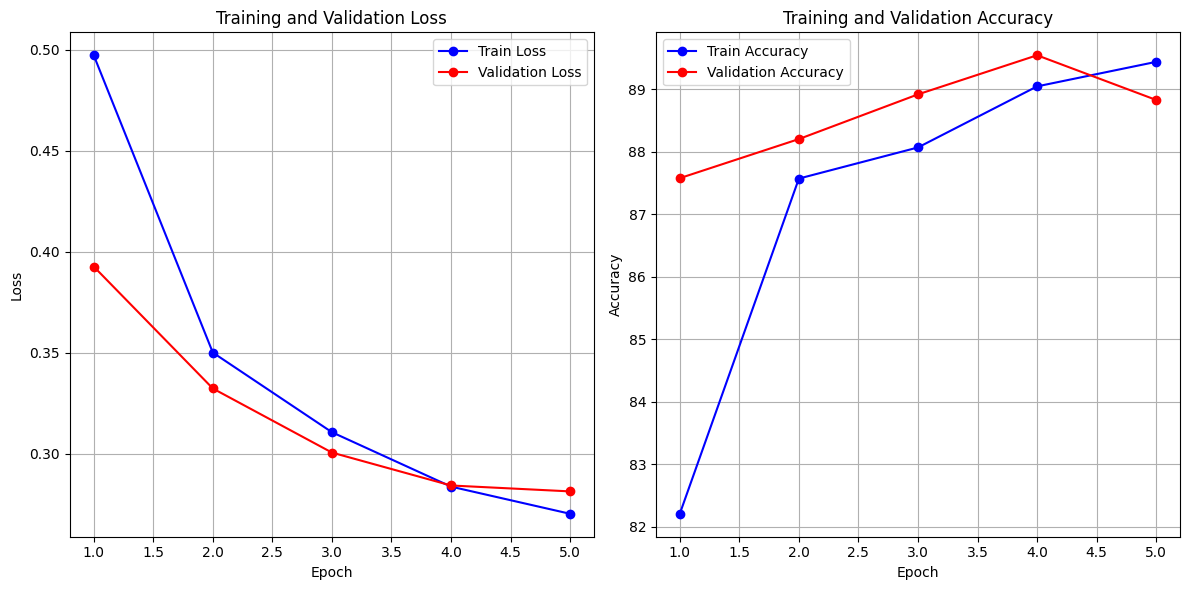

In [62]:
plot_from_history(history)

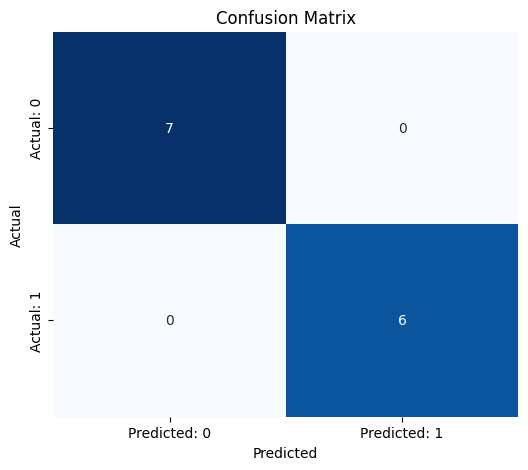

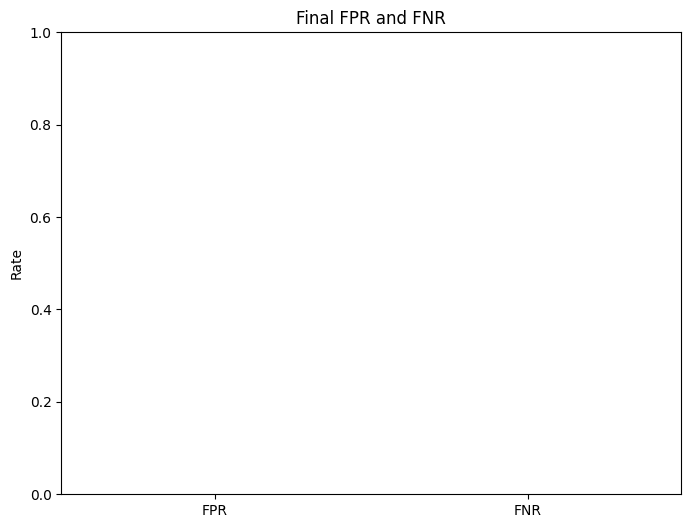

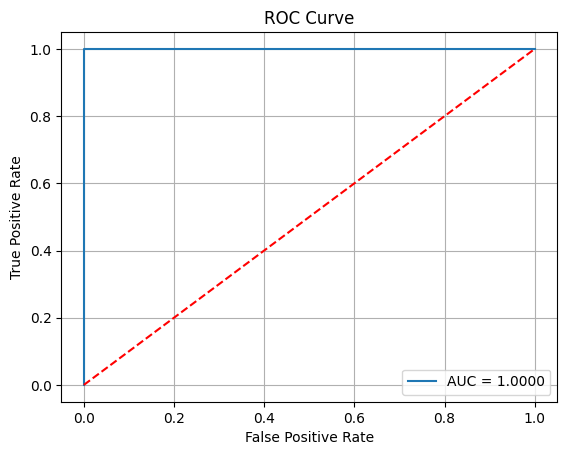

In [11]:
metrics_flat = {
    "class_names": metrics["class_names"],
    "fpr": metrics["fpr"],
    "fnr": metrics["fnr"],
    "auc_roc": metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in metrics["confusion_matrix"]]
}

# plot_roc_curve(metrics_flat)
plot_metrics(metrics_flat)

### Save training results

In [12]:

with open("training_history/Baseline_classification_reportv11.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_true, y_pred)}\n") 

df = pd.DataFrame(history)
df.to_csv('training_history/Baseline_training_historyv7.csv', index=False)
metrics_df = pd.DataFrame(metrics_flat)
metrics_df.to_csv('training_history/Baseline_training_metricsv7.csv', index=False)



#### Read Train Results

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.92      0.96        12

    accuracy                           0.93        15
   macro avg       0.88      0.96      0.91        15
weighted avg       0.95      0.93      0.94        15

Accuracy Score: 0.9333333333333333



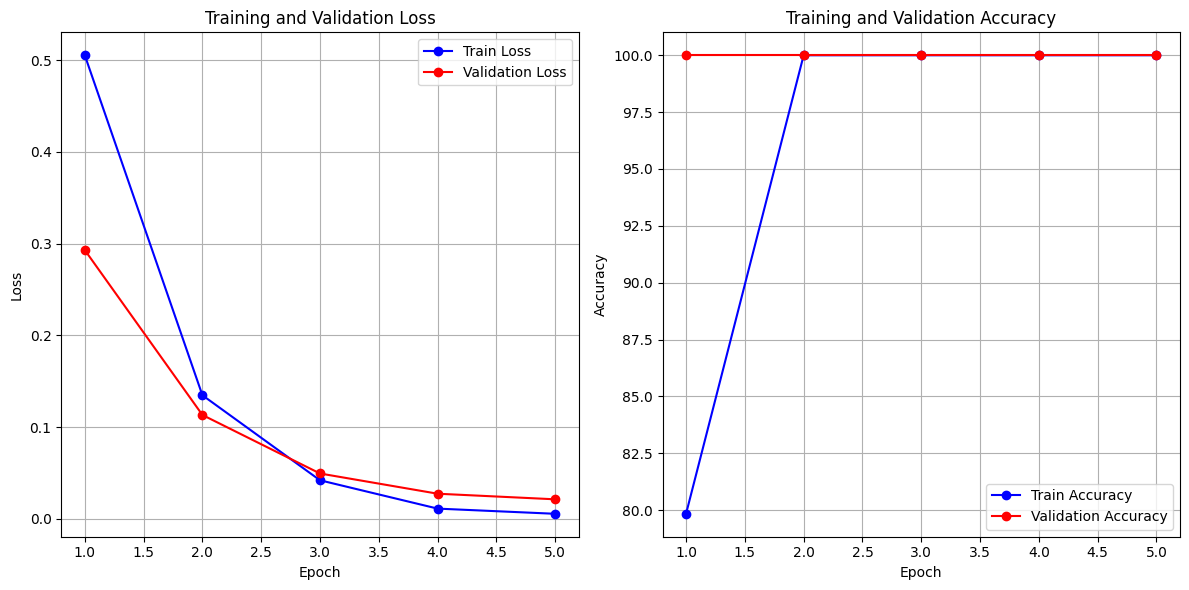

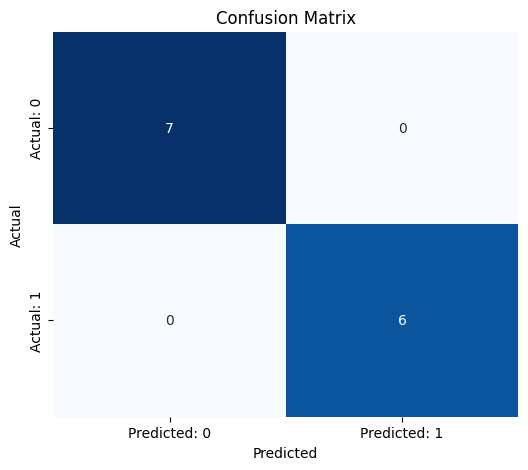

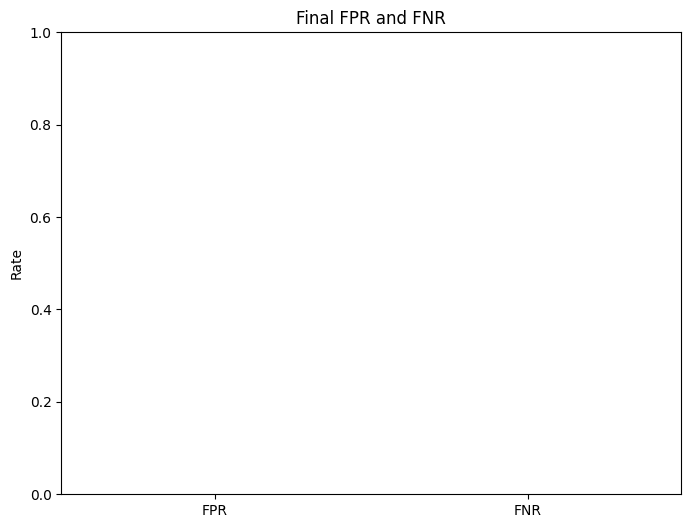

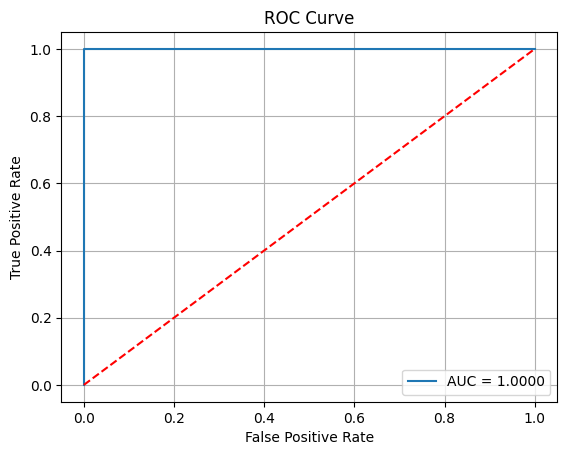

In [33]:
with open("training_history/Baseline_classification_reportv11.txt", "r") as file:
    report = file.read()

print(report)

history_df = pd.read_csv('training_history/Baseline_training_historyv7.csv')
history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(history)
metrics_df = pd.read_csv('training_history/Baseline_training_metricsv7.csv')

plot_metrics(metrics_df)

##  Save Models


In [14]:
torch.save(base_model_resnet, "../Saved models/Baseline_resnet_fullmodel_croppedv7.pth")
scripted_model = torch.jit.script(base_model_resnet)  # Convert model to TorchScript
scripted_model.save("../Saved models/Baseline_resnet_fullmodel_croppedv7.pt")

### Use saved Model

In [15]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


base_model = torch.jit.load("../Saved models/Baseline_resnet_fullmodel_croppedv7.pt")
base_model.to(device)
base_model.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])


def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    
    return img_tensor_resnet

def predict_image(img_path):
    img_tensor_resnet = preprocess_image(img_path)
    img_tensor_resnet = img_tensor_resnet.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = base_model(img_tensor_resnet)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Inappropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Appropriate
